# Anomaly Detection and Churn Prediction Model Training

This notebook demonstrates how to train models for anomaly detection and churn prediction using simulated data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Generation

In [2]:
# Generate simulated customer data
n_samples = 10000

# Create normal customer behavior
data = {
    'customer_id': range(1, n_samples + 1),
    'monthly_charges': np.random.normal(70, 20, n_samples),
    'total_charges': np.random.normal(2000, 800, n_samples),
    'tenure_months': np.random.randint(1, 72, n_samples),
    'contract_length': np.random.choice([1, 12, 24], n_samples, p=[0.3, 0.4, 0.3]),
    'support_calls': np.random.poisson(2, n_samples),
    'payment_failures': np.random.poisson(0.5, n_samples),
    'service_usage_hours': np.random.exponential(50, n_samples),
    'satisfaction_score': np.random.normal(3.5, 1, n_samples)
}

df = pd.DataFrame(data)

# Ensure positive values
df['monthly_charges'] = np.abs(df['monthly_charges'])
df['total_charges'] = np.abs(df['total_charges'])
df['satisfaction_score'] = np.clip(df['satisfaction_score'], 1, 5)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (10000, 9)


,customer_id,monthly_charges,total_charges,tenure_months,contract_length,support_calls,payment_failures,service_usage_hours,satisfaction_score
0,1,79.934283,1457.204216,32,24,0,0,107.255641,3.587656
1,2,67.234714,1755.600430,18,1,3,0,29.920034,3.573000
2,3,82.953771,1522.095151,68,1,0,0,21.474154,4.596385
3,4,100.460597,2088.334438,35,1,0,0,254.041336,5.000000
4,5,65.316933,2957.742825,23,1,5,1,9.286931,4.921208


## 2. Create Churn Labels

In [3]:
# Create churn probability based on features
churn_probability = (
    0.3 * (df['satisfaction_score'] < 2.5) +
    0.2 * (df['support_calls'] > 5) +
    0.2 * (df['payment_failures'] > 2) +
    0.1 * (df['tenure_months'] < 6) +
    0.1 * (df['monthly_charges'] > 100) +
    0.1 * np.random.random(n_samples)
)

# Convert probability to binary labels
df['churn'] = (churn_probability > 0.3).astype(int)

print(f"Churn rate: {df['churn'].mean():.2%}")
print(f"Churn distribution:")
print(df['churn'].value_counts())

Churn rate: 16.68%
Churn distribution:
churn
0    8332
1    1668
Name: count, dtype: int64


## 3. Introduce Anomalies

In [4]:
# Create anomalous data points (5% of dataset)
n_anomalies = int(0.05 * n_samples)
anomaly_indices = np.random.choice(df.index, n_anomalies, replace=False)

# Introduce extreme values for anomalies
df.loc[anomaly_indices, 'monthly_charges'] *= np.random.uniform(3, 8, n_anomalies)
df.loc[anomaly_indices, 'support_calls'] *= np.random.randint(5, 15, n_anomalies)
df.loc[anomaly_indices, 'payment_failures'] *= np.random.randint(3, 10, n_anomalies)
df.loc[anomaly_indices, 'service_usage_hours'] *= np.random.uniform(0.1, 0.3, n_anomalies)

# Create anomaly labels
df['is_anomaly'] = 0
df.loc[anomaly_indices, 'is_anomaly'] = 1

print(f"Anomaly rate: {df['is_anomaly'].mean():.2%}")

Anomaly rate: 5.00%


## 4. Exploratory Data Analysis

In [5]:
# Basic statistics
df.describe()

,customer_id,monthly_charges,total_charges,tenure_months,contract_length,support_calls,payment_failures,service_usage_hours,satisfaction_score,churn,is_anomaly
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,85.782299,2014.810955,36.178200,12.294000,2.84410,0.618900,48.280014,3.471583,0.166800,0.050000
std,2886.89568,79.568125,790.730794,20.586307,8.890774,5.13833,1.343147,50.011788,0.943340,0.372816,0.217956
min,1.00000,2.021702,6.088279,1.000000,1.000000,0.00000,0.000000,0.016558,1.000000,0.000000,0.000000
25%,2500.75000,57.401607,1470.391276,18.000000,1.000000,1.00000,0.000000,12.787703,2.806323,0.000000,0.000000
50%,5000.50000,71.316803,2012.677373,36.000000,12.000000,2.00000,0.000000,32.676213,3.502287,0.000000,0.000000
75%,7500.25000,85.957637,2555.091896,54.000000,24.000000,3.00000,1.000000,66.709341,4.177106,0.000000,0.000000
max,10000.00000,972.959965,5583.267401,71.000000,24.000000,78.00000,24.000000,466.897193,5.000000,1.000000,1.000000


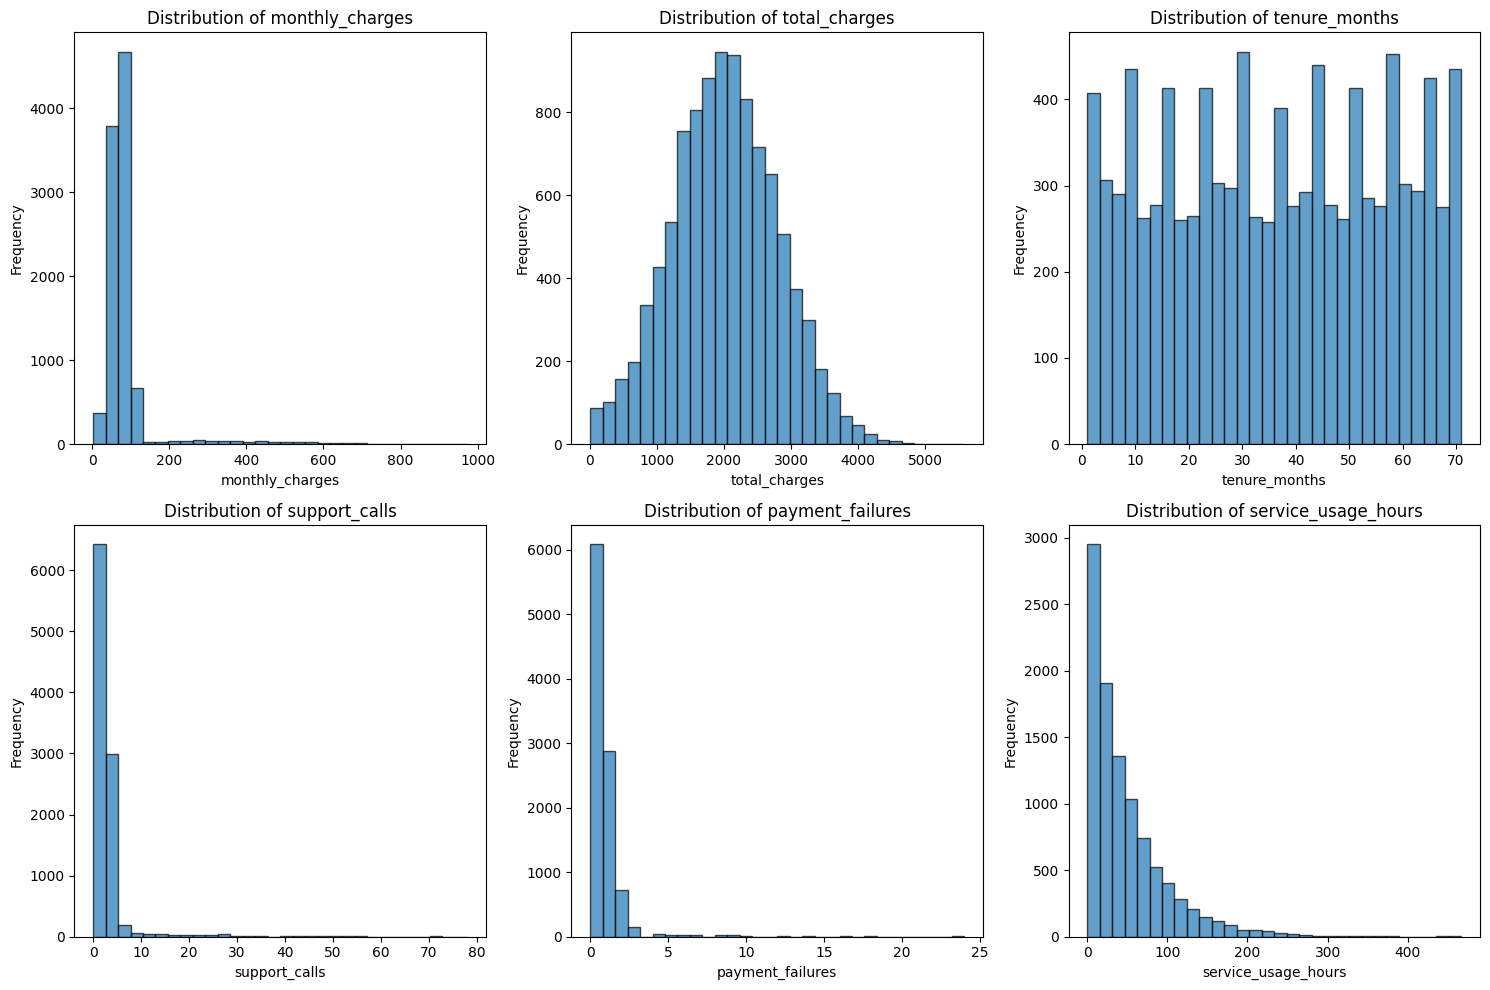

In [6]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

numerical_cols = ['monthly_charges', 'total_charges', 'tenure_months', 
                 'support_calls', 'payment_failures', 'service_usage_hours']

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

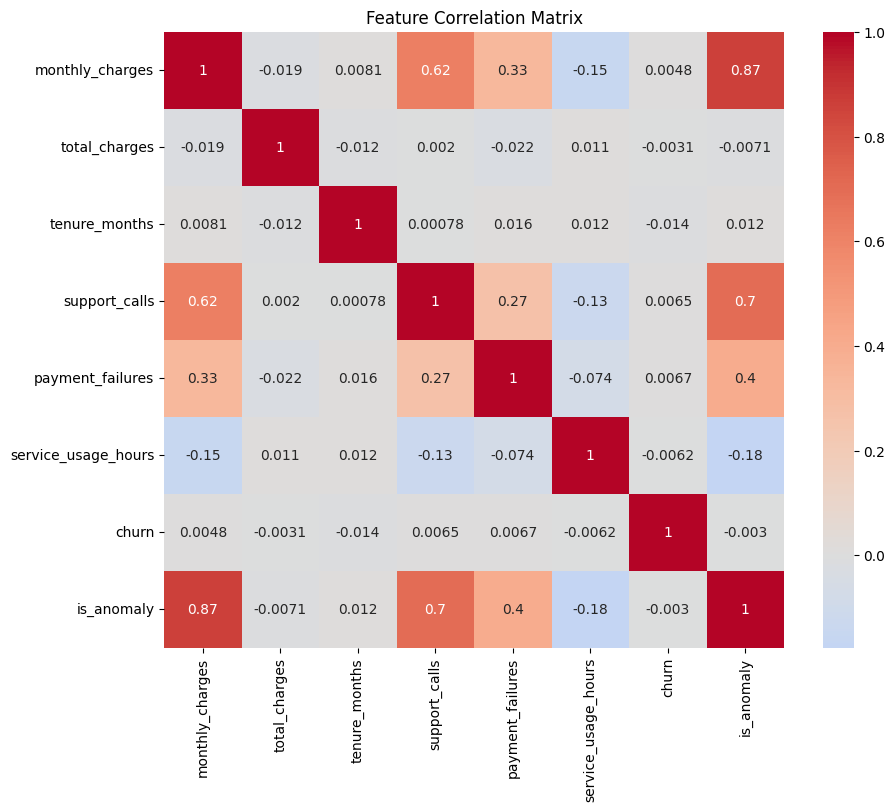

In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols + ['churn', 'is_anomaly']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

## 5. Anomaly Detection Model Training

In [8]:
# Prepare features for anomaly detection
anomaly_features = ['monthly_charges', 'total_charges', 'tenure_months', 
                   'support_calls', 'payment_failures', 'service_usage_hours', 
                   'satisfaction_score']

X_anomaly = df[anomaly_features].copy()

# Scale features
scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

# Train Isolation Forest for anomaly detection
isolation_forest = IsolationForest(
    contamination=0.05,  # Expected proportion of anomalies
    random_state=42,
    n_estimators=100
)

# Fit the model
anomaly_predictions = isolation_forest.fit_predict(X_anomaly_scaled)

# Convert predictions to binary (1 for normal, -1 for anomaly)
anomaly_predictions_binary = (anomaly_predictions == -1).astype(int)

print("Anomaly Detection Results:")
print(f"Predicted anomalies: {anomaly_predictions_binary.sum()}")
print(f"Actual anomalies: {df['is_anomaly'].sum()}")
print(f"\nClassification Report:")
print(classification_report(df['is_anomaly'], anomaly_predictions_binary))

Anomaly Detection Results:
Predicted anomalies: 500
Actual anomalies: 500

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9500
           1       0.75      0.75      0.75       500

    accuracy                           0.98     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.98      0.98      0.98     10000



## 6. Churn Prediction Model Training

In [9]:
# Prepare features for churn prediction
churn_features = ['monthly_charges', 'total_charges', 'tenure_months', 
                 'contract_length', 'support_calls', 'payment_failures', 
                 'service_usage_hours', 'satisfaction_score']

X_churn = df[churn_features]
y_churn = df['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

# Scale features
scaler_churn = StandardScaler()
X_train_scaled = scaler_churn.fit_transform(X_train)
X_test_scaled = scaler_churn.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

Training set size: (8000, 8)
Test set size: (2000, 8)
Training churn rate: 16.68%
Test churn rate: 16.70%


In [10]:
# Train Random Forest for churn prediction
rf_churn = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

# Fit the model
rf_churn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_churn.predict(X_test_scaled)
y_pred_proba = rf_churn.predict_proba(X_test_scaled)[:, 1]

print("Churn Prediction Results:")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Churn Prediction Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1666
           1       1.00      0.97      0.98       334

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000


ROC AUC Score: 0.9997


## 7. Feature Importance Analysis

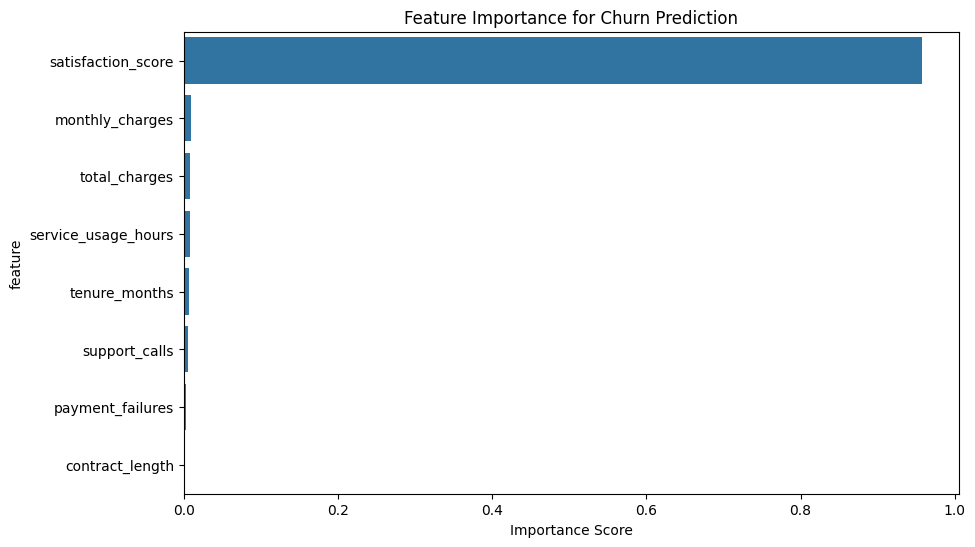

Feature Importance Ranking:
               feature  importance
7   satisfaction_score    0.957062
0      monthly_charges    0.009792
1        total_charges    0.008224
6  service_usage_hours    0.007648
2        tenure_months    0.006965
4        support_calls    0.005070
5     payment_failures    0.003586
3      contract_length    0.001652


In [11]:
# Feature importance for churn prediction
feature_importance = pd.DataFrame({
    'feature': churn_features,
    'importance': rf_churn.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance Score')
plt.show()

print("Feature Importance Ranking:")
print(feature_importance)

## 8. Model Evaluation Visualizations

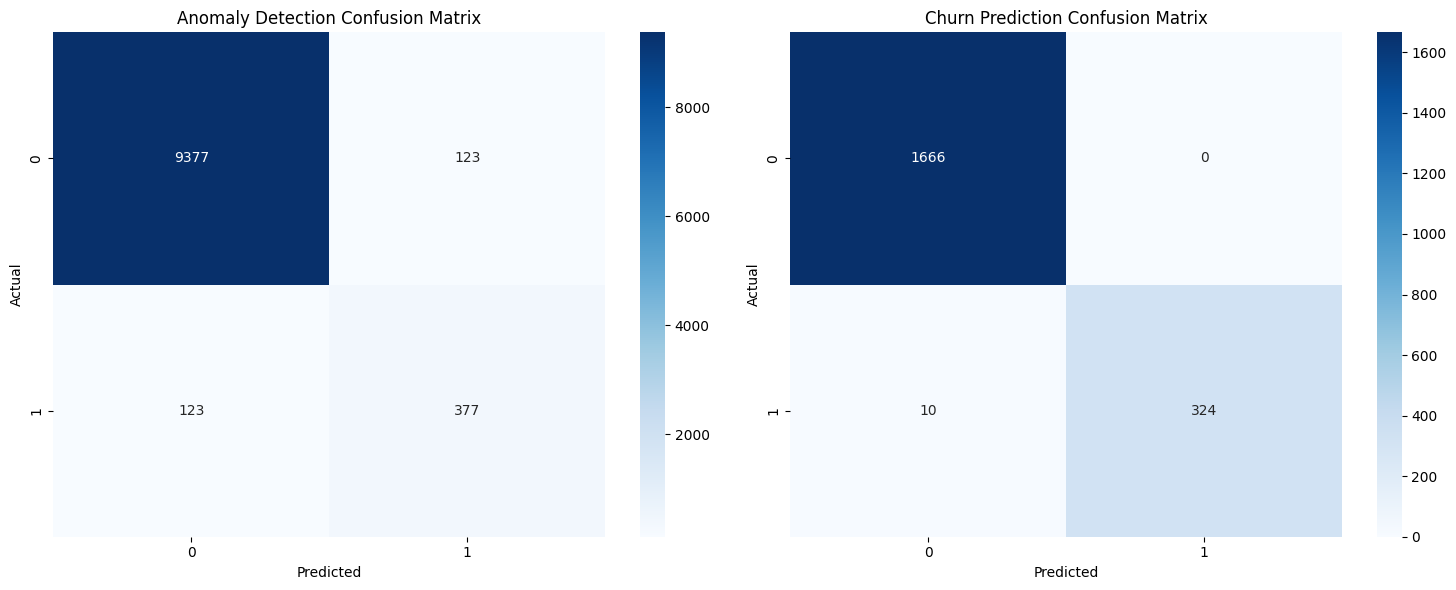

In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Anomaly detection confusion matrix
cm_anomaly = confusion_matrix(df['is_anomaly'], anomaly_predictions_binary)
sns.heatmap(cm_anomaly, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Anomaly Detection Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Churn prediction confusion matrix
cm_churn = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_churn, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Churn Prediction Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 9. Model Deployment Preparation

In [13]:
import joblib

# Save trained models and scalers
joblib.dump(isolation_forest, 'anomaly_detection_model.pkl')
joblib.dump(rf_churn, 'churn_prediction_model.pkl')
joblib.dump(scaler_anomaly, 'anomaly_scaler.pkl')
joblib.dump(scaler_churn, 'churn_scaler.pkl')

print("Models saved successfully!")
print("Files created:")
print("- anomaly_detection_model.pkl")
print("- churn_prediction_model.pkl")
print("- anomaly_scaler.pkl")
print("- churn_scaler.pkl")

Models saved successfully!
Files created:
- anomaly_detection_model.pkl
- churn_prediction_model.pkl
- anomaly_scaler.pkl
- churn_scaler.pkl


## 10. Sample Predictions

In [14]:
# Example of making predictions on new data
sample_data = pd.DataFrame({
    'monthly_charges': [85.0, 45.0, 150.0],
    'total_charges': [2500.0, 800.0, 5000.0],
    'tenure_months': [24, 6, 60],
    'contract_length': [12, 1, 24],
    'support_calls': [2, 8, 1],
    'payment_failures': [0, 3, 0],
    'service_usage_hours': [45.0, 20.0, 80.0],
    'satisfaction_score': [4.0, 2.0, 4.5]
})

# Anomaly detection predictions
sample_anomaly_scaled = scaler_anomaly.transform(sample_data[anomaly_features])
anomaly_pred = isolation_forest.predict(sample_anomaly_scaled)

# Churn predictions
sample_churn_scaled = scaler_churn.transform(sample_data[churn_features])
churn_pred = rf_churn.predict(sample_churn_scaled)
churn_proba = rf_churn.predict_proba(sample_churn_scaled)[:, 1]

results = pd.DataFrame({
    'Customer': ['Customer_1', 'Customer_2', 'Customer_3'],
    'Is_Anomaly': (anomaly_pred == -1),
    'Will_Churn': churn_pred,
    'Churn_Probability': churn_proba.round(4)
})

print("Sample Predictions:")
print(results)

Sample Predictions:
     Customer  Is_Anomaly  Will_Churn  Churn_Probability
0  Customer_1       False           0             0.0083
1  Customer_2       False           1             0.9258
2  Customer_3       False           0             0.0314
